# Z gate oscillations on prospective physical cat qubits

This notebook studies the bit flip scaling, phase flip scaling, and oscillations of the Z gate on an emulator of physical cat qubits. It is a preliminary to the notebook entitled "Study of error detection codes on prospective physical cat qubits". The objective is to study the individual properties of the qubits used in the model, before jumping to the study of multi-qubit circuits.

The emulator is configured to have the same properties as the qubits used in the paper [High-performance repetition cat code using fast noisy operations](https://arxiv.org/abs/2212.11927) [Le Régent et al., 2022]. This model does not represent the current performance of Alice & Bob's cat qubits.

## Helper code for demo (skip)

In [1]:
from qiskit import QuantumCircuit, execute, transpile
from typing import Optional
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
from tqdm.notebook import tqdm
import warnings

# set default plot parameters
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',

    'font.family': 'serif',
    'font.size': 16,

    'figure.dpi': 72.0,

    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 5.0,
    'xtick.minor.size': 2.5,
    'ytick.major.size': 5.0,
    'ytick.minor.size': 2.5,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,

    'axes.grid': True,
    'axes.titlesize': 'larger',
    'axes.labelsize': 'larger',
    'legend.fontsize': 'larger',
    'grid.color': 'gray',
    'grid.linestyle': '--',
    'grid.alpha': 0.3,

    'lines.linewidth': 1.0,
    
    'figure.figsize': (16, 8)
})

In [2]:
def fitted_curve(t, T, a, b):
    return a * np.exp(- t / T) + b

def fit_typical_time(delay_durations, probs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        opt, _ = sp.optimize.curve_fit(
            fitted_curve, delay_durations, probs, 
            p0=[np.median(delay_durations), probs[0] - probs[-1], probs[-1]],
            method='trf'
        )
        return opt

## Instantiating the emulator

In [3]:
from qiskit_alice_bob_provider.local.provider import AliceBobLocalProvider
from qiskit_alice_bob_provider.local.backend import ProcessorSimulator
from qiskit_alice_bob_provider.processor.physical_cat import PhysicalCatProcessor
from qiskit_aer import AerSimulator

provider = AliceBobLocalProvider()

In [4]:
provider.backends()

[<ProcessorSimulator(name=EMU:6Q:PHYSICAL_CATS)>,
 <ProcessorSimulator(name=EMU:40Q:PHYSICAL_CATS)>,
 <ProcessorSimulator(name=EMU:40Q:LOGICAL_TARGET)>,
 <ProcessorSimulator(name=EMU:40Q:LOGICAL_EARLY)>,
 <ProcessorSimulator(name=EMU:1Q:LESCANNE_2020)>]

In [5]:
backend = provider.get_backend('EMU:40Q:PHYSICAL_CATS')

## Single qubit bit flip time $T_{bf}$ as a function of $\bar n = |\alpha|^2$

In [6]:
def build_bit_flip_circuit(delay_duration_s: float) -> QuantumCircuit:
    circ = QuantumCircuit(1, 1)
    circ.initialize(0)
    circ.delay(delay_duration_s, 0, unit='s')
    circ.measure(0, 0)
    return circ

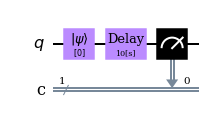

In [7]:
circ = build_bit_flip_circuit(10)
circ.draw('mpl')

In [25]:
nbars = np.linspace(4, 12, 7)
delay_durations_s = np.logspace(-4, 10, 10)
k1s = [100, 1_000, 10_000]
k2 = 10_000_000
shots = 1_000

In [26]:
tbf_fitted = {}

for k1 in tqdm(k1s):
    tbf_fitted[k1] = []
    for nbar in tqdm(nbars):
        backend = provider.get_backend('EMU:40Q:PHYSICAL_CATS', average_nb_photons=nbar, kappa_1=k1, kappa_2=k2)
        jobs = []
        for delay_duration_s in delay_durations_s:
            circ = build_bit_flip_circuit(delay_duration_s)
            jobs.append(execute(circ, backend, shots=shots))
        results = [job.result() for job in jobs]
        flip_fractions = [r.get_counts().get('1', 0) / shots for r in results]
        Tbf, a, b = fit_typical_time(delay_durations_s, flip_fractions)
        tbf_fitted[k1].append(Tbf)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

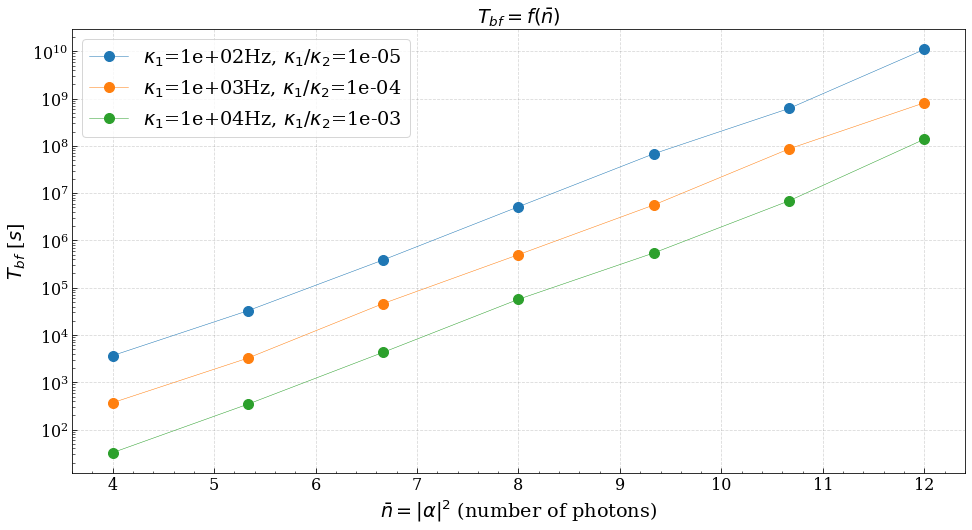

In [27]:
plt.figure()
plt.title('$T_{bf}=f(\\bar{n})$')
plt.xlabel('$\\bar{n} = |\\alpha|^2$ (number of photons)')
plt.ylabel('$T_{bf}$ [$s$]')
for k1 in k1s:
    plt.plot(nbars, tbf_fitted[k1], label=f'$\\kappa_1$={k1:.0e}Hz, $\\kappa_1/\\kappa_2$={k1/k2:.0e}',
            lw=0.5, marker='o', ms=10)
plt.semilogy()
plt.legend()
plt.show()

We observe an exponential suppression of bit flip errors (an exponential increase of the bit flip time $T_{bf}$).

## Single qubit phase flip rate $\Gamma_{pf}$ as a function of $\bar n = |\alpha|^2$

In [12]:
def build_phase_flip_circuit(delay_duration_s: float) -> QuantumCircuit:
    circ = QuantumCircuit(1, 1)
    circ.initialize('+')
    circ.delay(delay_duration_s, 0, unit='s')
    circ.measure_x(0, 0)
    return circ

/home/jdumazer/ab/emulation-examples/venv/lib/python3.9/site-packages/qiskit/utils/classtools.py:112: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  retval = method(*args, **kwargs)


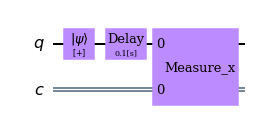

In [13]:
circ = build_phase_flip_circuit(0.1)
circ.draw('mpl')

In [14]:
nbars = np.linspace(4, 16, 7)
delay_durations_s = np.logspace(-8, -1, 10)
k1s = [100, 1_000]
k2 = 10_000_000
shots = 10_000

In [15]:
tpf_fitted = {}

for k1 in tqdm(k1s):
    tpf_fitted[k1] = []
    for nbar in tqdm(nbars):
        backend = provider.get_backend('EMU:40Q:PHYSICAL_CATS', average_nb_photons=nbar, kappa_1=k1, kappa_2=k2)
        jobs = []
        for delay_duration_s in delay_durations_s:
            circ = build_phase_flip_circuit(delay_duration_s)
            jobs.append(execute(circ, backend, shots=shots))
        results = [job.result() for job in jobs]
        flip_fractions = [r.get_counts().get('1', 0) / shots for r in results]
        Tpf, a, b = fit_typical_time(delay_durations_s, flip_fractions)
        tpf_fitted[k1].append(Tpf)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

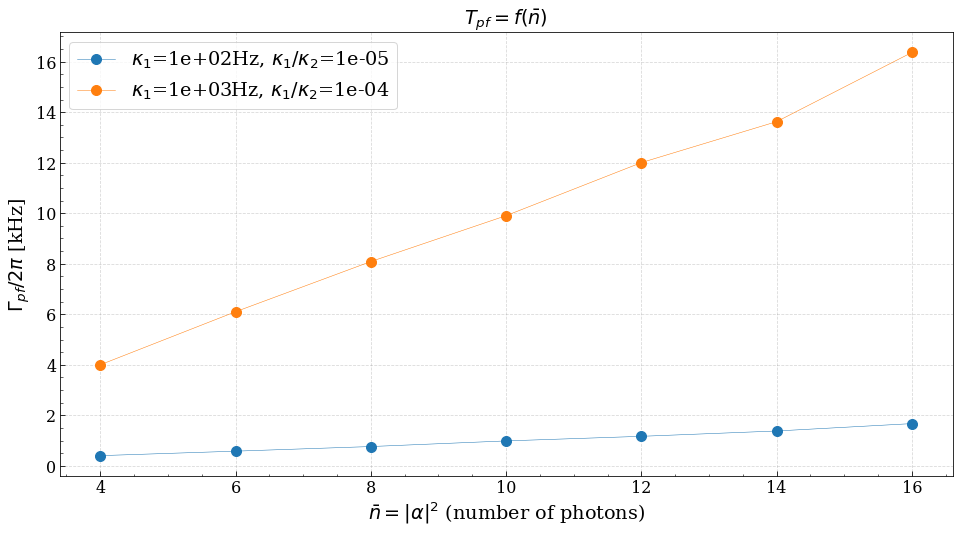

In [16]:
plt.figure()
plt.title('$T_{pf}=f(\\bar{n})$')
plt.xlabel('$\\bar{n} = |\\alpha|^2$ (number of photons)')
plt.ylabel('$\\Gamma_{pf}/2\\pi$ [kHz]')
for k1 in k1s:
    plt.plot(nbars, 0.5/np.array(tpf_fitted[k1]) * 1e-3, label=f'$\\kappa_1$={k1:.0e}Hz, $\\kappa_1/\\kappa_2$={k1/k2:.0e}',
            lw=0.5, marker='o', ms=10)
plt.legend()
plt.show()

We observe a linear increase of the number of bit flip errors (a linear increase in the bit flip rate $\Gamma_{pf}$).

## Single qubit Z gate oscillations

In [17]:
def build_oscillation_circuit(angle: float) -> QuantumCircuit:
    circ = QuantumCircuit(1, 1)
    circ.initialize('+')
    circ.rz(angle, 0)
    circ.measure_x(0, 0)
    return circ

/home/jdumazer/ab/emulation-examples/venv/lib/python3.9/site-packages/qiskit/utils/classtools.py:112: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  retval = method(*args, **kwargs)


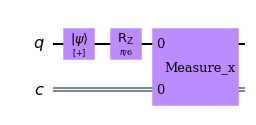

In [18]:
circ = build_oscillation_circuit(np.pi / 6)
circ.draw('mpl')

In [19]:
nbars = [9, 16, 25]
angles = np.linspace(0, 15 * np.pi, 150)
shots = 10_000
k1 = 100
k2 = 10_000

In [20]:
curves = {}
durations = {}

for nbar in tqdm(nbars):
    curves[nbar] = []
    durations[nbar] = []
    backend = provider.get_backend('EMU:40Q:PHYSICAL_CATS', average_nb_photons=nbar, kappa_2=k2, kappa_1=k1)
    jobs = []
    for angle in angles:
        circ = build_oscillation_circuit(angle)
        jobs.append(execute(circ, backend, shots=shots))
    results = [job.result() for job in jobs]
    flip_fractions = [r.get_counts().get('1', 0) / shots for r in results]
    durations_ = [job.circuits()[0].duration * backend.dt for job in jobs]
    curves[nbar].append(flip_fractions)
    durations[nbar].append(durations_)

  0%|          | 0/3 [00:00<?, ?it/s]

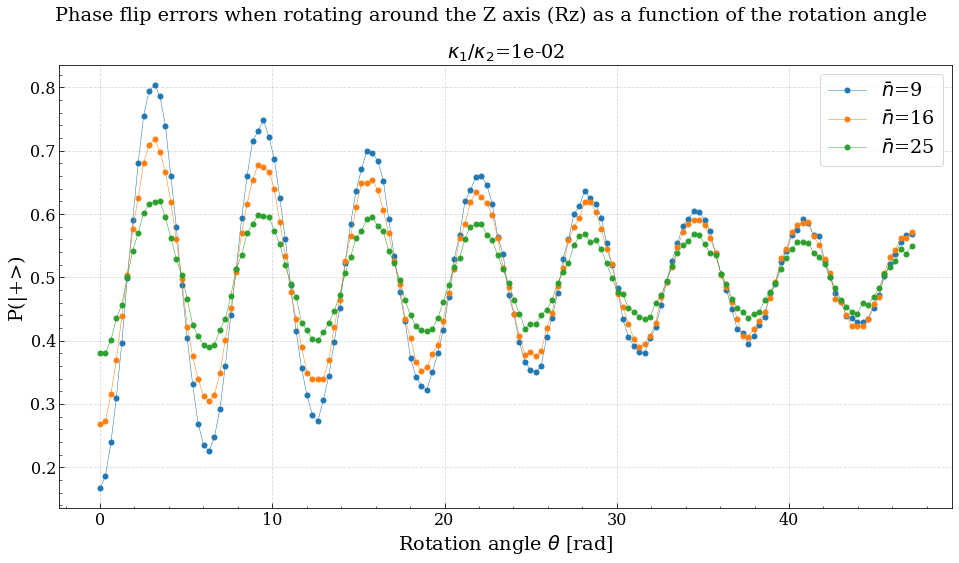

In [21]:
plt.figure()
plt.suptitle('Phase flip errors when rotating around the Z axis (Rz) as a function of the rotation angle')
plt.title(f'$\\kappa_1/\\kappa_2$={k1/k2:.0e}')
plt.xlabel('Rotation angle $\\theta$ [rad]')
plt.ylabel('P(|+>)')
for nbar in nbars:
    plt.plot(angles, np.squeeze(curves[nbar]), lw=0.5, marker='o', ms=5, label=f'$\\bar n$={nbar}')
plt.legend()
plt.show()

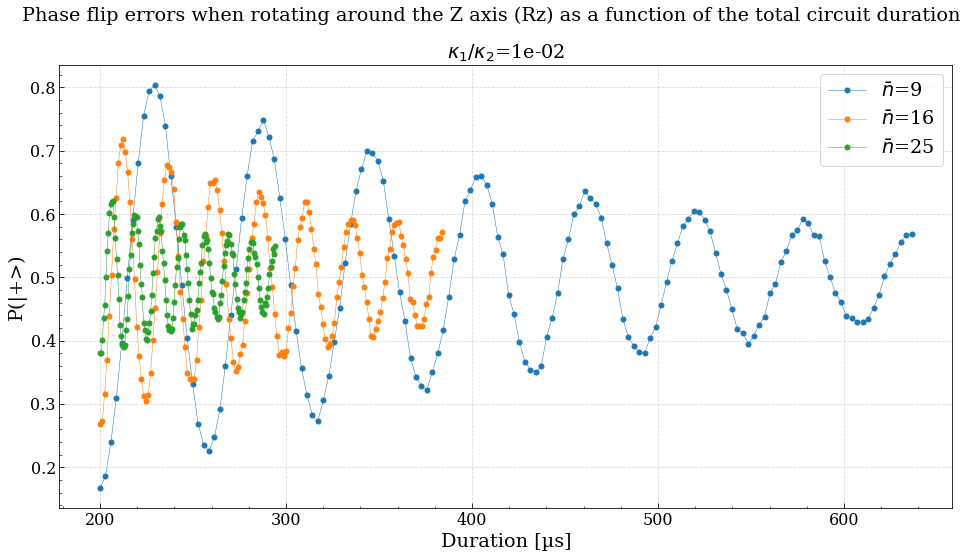

In [22]:
plt.figure()
plt.suptitle('Phase flip errors when rotating around the Z axis (Rz) as a function of the total circuit duration')
plt.title(f'$\\kappa_1/\\kappa_2$={k1/k2:.0e}')
plt.xlabel('Duration [µs]')
plt.ylabel('P(|+>)')
for nbar in nbars:
    plt.plot(np.squeeze(durations[nbar]) * 1e6, np.squeeze(curves[nbar]), lw=0.5, marker='o', ms=5, label=f'$\\bar n$={nbar}')
plt.legend()
plt.show()